In [2]:
%load_ext autotime
import warnings; warnings.filterwarnings('ignore')

In [3]:
import numpy as np, pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt, glob
import matplotlib as mpl, salem
import rasterio, xarray as xr
from rasterio import features
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from rasterio.plot import reshape_as_raster, reshape_as_image

time: 2.28 s


/home/pankaj/.local/Anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
def plot_data(img, ax=None, fig=None, cmap=None):
        if not ax:
            fig, ax = plt.subplots(1, 1, figsize=(10,10))
        ax.imshow(img, cmap=cmap)
        ax.axis('off')
        if fig:
            return fig, ax

time: 3.74 ms


In [10]:
shapefile = '/home/pankaj/phd/practice/sur/data/neshpfile/NE_utm.shp'
shape = gpd.read_file(shapefile)
files = glob.glob('/mnt/ext1/data/sur/lulc/Decadal_LULC_India_1336/data/*.tif')
files = sorted(files)
files

['/mnt/ext1/data/sur/lulc/Decadal_LULC_India_1336/data/LULC_1985.tif',
 '/mnt/ext1/data/sur/lulc/Decadal_LULC_India_1336/data/LULC_1995.tif',
 '/mnt/ext1/data/sur/lulc/Decadal_LULC_India_1336/data/LULC_2005.tif',
 '/mnt/ext1/data/sur/lulc/Decadal_LULC_India_1336/data/LULC_2015.tif']

time: 13.2 ms


In [5]:
label1 = pd.read_csv('/mnt/ext1/data/sur/lulc/Decadal_LULC_India_1336/data/labels.txt',\
                     header=None, sep='- ', names=['index', 'labels', 'new']).set_index('index')
label2 = pd.read_csv('/mnt/ext1/data/sur/lulc/Decadal_LULC_India_1336/data/labels.2015.txt',\
                     header=None, sep='- ', names=['index', 'labels', 'new']).set_index('index')

time: 49.2 ms


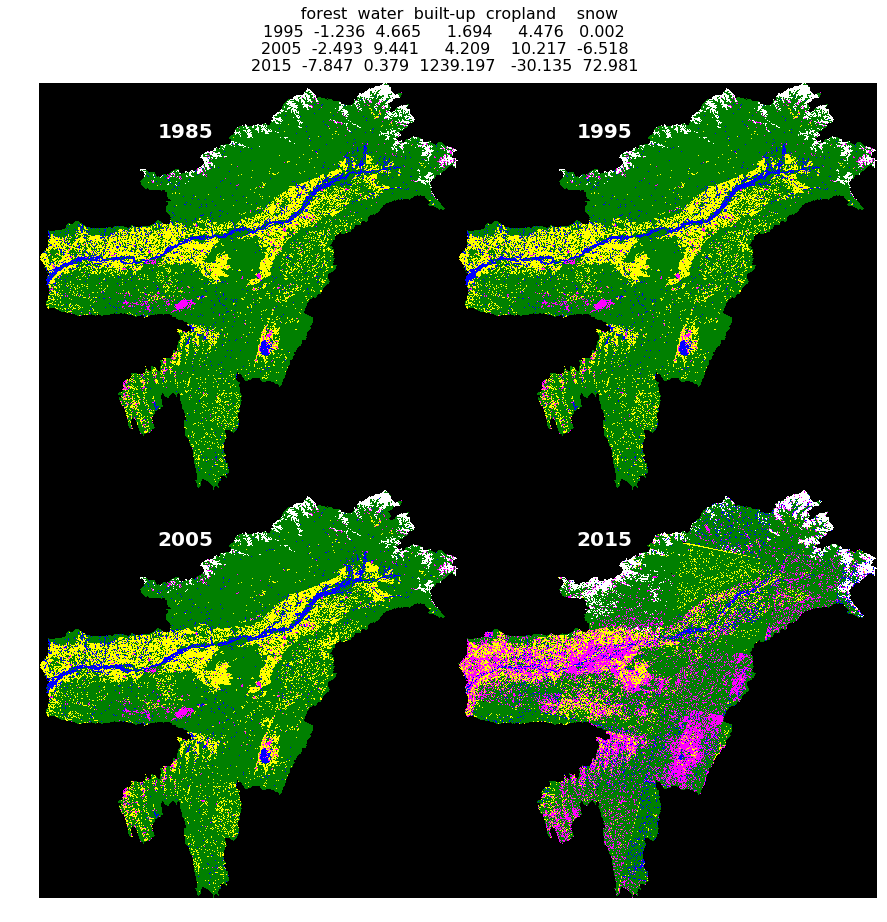

time: 14.5 s


In [21]:
counts = []
years  = []
cdir = '/mnt/ext1/data/sur/lulc/Decadal_LULC_India_1336/data/cropped/'
cmap = mpl.colors.ListedColormap(['green', 'blue',  'magenta', 'yellow', 'white', 'black'])
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()
for i, (filename, ax) in enumerate(zip(files, axes)):
    year = filename.split('_')[-1].split('.')[0]
    years.append(year)
    cropfile = cdir + filename.split('/')[-1]
    #!gdalwarp -overwrite -t_srs EPSG:4326 -crop_to_cutline -dstalpha -cutline $shapefile $filename $cropfile
    if i!=3:
        with rasterio.open(cropfile) as infile:
            img = infile.read(1) 
        for idx in label1.index:
            img[img==idx] = label1.loc[idx,'new']
    else:
        with rasterio.open(filename) as infile:
            img = infile.read(1) 
        for idx in label2.index:
            img[img==idx] = label2.loc[idx,'new']
    unique, count = np.unique(img, return_counts=True)
    counts.append(count)
    ax.imshow(img, cmap=cmap)
    ax.set_title(year, x=0.35, y=0.85, fontsize=20, \
                 fontweight='bold', color='white')
    ax.axis('off')
classes = ['forest', 'water', 'built-up', 'cropland', 'snow', 'background']
cnt = pd.DataFrame(counts, index=years, columns=classes).sort_index()
base = cnt.loc['1985', :]
change = 100*(cnt - base) / base
change = change.drop(['background'], axis=1).drop(['1985']).round(3)
fig.suptitle(change, y=0.95, fontsize=16)
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('./plots/change.png')
plt.show()